<a href="https://colab.research.google.com/github/rileykc98/425-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP425/6341 Computer Vision - Project skeleton

## 0 Import KMNIST dataset (1 pts)

In [1]:
# import required libraries, DO NOT MODIFY!
import torch
import torchvision
from torchvision.datasets import ImageFolder,KMNIST
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import numpy as np


In [2]:
### set random seed to your Student ID
random_seed = 40048739
torch.manual_seed(random_seed);

Run the cells below to initialize the train and test loaders for KMNIST and visualize one of its samples.

**Experiments:** <br>
1. Change `batch_size` based on the device you are using.<br>
2. Try more complicated transformations on train set.<br>
3. Visualize different samples from the dataset.

In [3]:
# datasets hyper parameters
batch_size = 20
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# Initialize kmnist train and test datasets
# These two lines will download the datasets in a folder called KMNIST.
# The folder will be written in the same directory as this script.
# The download will occur once. Subsequent executions will not re-download the datasets if they exist.
kmnist_train_set = KMNIST(root='.',
                         train=True,
                         download=True,
                         transform=train_transform)
kmnist_test_set = KMNIST(root='.',
                         train=False,
                         download=True,
                         transform=test_transform)

# Initialize kmnist train and test data loaders. 
kmnist_train_loader = torch.utils.data.DataLoader(kmnist_train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
kmnist_test_loader = torch.utils.data.DataLoader(kmnist_test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

label: 5


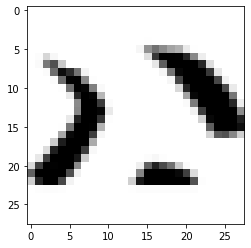

In [4]:
plt.imshow(kmnist_train_set[10][0][0],cmap="gray_r")
print("label:", kmnist_train_set[10][1])

## 1 Feed-forward Neural network
In this section, you will implement a simple feed-forward network from scratch. Follow the instructions/comments in each subsection to complete the general structure of the network.

### 1.1 Activation Functions (4 + 4 + 4 pts)
Implement [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [Identity](https://en.wikipedia.org/wiki/Identity_function) functions. This functions will later be used in network architecture.

In [5]:
def Sigmoid(x):
    """ Identity activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    return torch.pow((torch.exp(-x) + 1), exponent = -1)
    
def ReLU(x):
    """ ReLU activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    zeros = torch.clone(x)
    zeros[zeros != 0] = 0
    return torch.maximum(x, zeros)

def Identity(x):
    """ Identity activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    return x

def get_activation(str): 
  if str == 'sig':
    return Sigmoid
  elif str == 'rel':
    return ReLU
  else:
    return Identity

### 1.2 Cross Entropy Loss (7.5 + 7.5 pts)
Implement the Softmax function and Cross Entropy loss.

In [6]:
def Softmax(x,dim):
    """ Softmax function
    Args:torch.log(
        x (torch.tensor): inputs tensor of size (B,F)
        dim (int): A dimension along which Softmax will be computed
    Return:
        torch.tensor: a tensor of shape of x
    """
    return torch.exp(x)/torch.sum(torch.exp(x),axis=dim)

def CE_loss(predictions,labels):
    """ Cross entropy loss
    Args:
        predictions (torch.tensor): tensor of shape of (B,C)
        labels (torch.tensor): tensor of shape of (B,1)
    Returns:
        torch.tensor: a tensor of shape of (1,)
    """
    loss=-torch.sum(torch.mul(labels, (torch.log(predictions))))
    return loss/float(predictions.shape[0])

### 1.3 Network (2.5 + 7.5 pts)
Complete the code for the simple feed-forward network shown below. 

Network parameters will be stored in a dictionary called `params`. weights and biases keys appear in the format `W#` and `b#` where `#` indicates the layer number. For example, the weights and biases of the first layer are `W1` and `b1`. Weights and biases are initialized inside `init_weights` function.

**Notes:** 
1. Set `requires_grad=True` when initializing weights and biases to have [pytorch automatic differentiation engine](https://pytorch.org/docs/stable/autograd.html) calculate the gradients.
2. Assign network parameters and inputs on the same `device`.
3. Initialize weights and biases with samples from normal distribution with mean 0 and variance 1.

In [7]:
class my_nn(nn.Module):
    def __init__(self,layers_dim,layers_activation=None,device='cpu'):
        """ Initialize network
        Args:
            layers_dims (List of ints): list of Size of each layer of the network
                                        [inputs,layer1,...,outputs]
            layers_activation (List of strings): list of activation function for each hidden layer
                                        of the network[layer1,...,outputs]
            device (str): a device that will be used for computation
                Default: 'cpu'
            
        """
        super(my_nn, self).__init__()
        self.layers_activation = [get_activation(x) for x in layers_activation]
        self.params = {}
        self.num_layers = len(layers_dim)-1
        self.layers_dim = layers_dim
        self.device = device
        self.init_weights()
        

    def init_weights(self):
        """ Initialize weights and biases of network based on layers dimension.
            Store weights and biases in self.params.
            weights and biases key should be of format "W#" and "b#" where # is the layer number.
            Example: for layer 1, weight and bias key is "W1" and "b1"
        Args:
            None
        
        Returns:
            None
        """
        for i in range(1, self.num_layers+1):
            self.params["W"+str(i)] = torch.tensor(np.random.randn(self.layers_dim[i-1], self.layers_dim[i])*0.01, device=self.device, requires_grad = True, dtype=torch.float)
            self.params["b"+str(i)] = torch.tensor(np.zeros((self.layers_dim[i], 1)), device=self.device, requires_grad = True, dtype=torch.float)
        pass

    def forward(self,x):
        """ Perform forward pass
        Args:
            x (torch.tensor): tensor of shape of (B, C, H, W)
        
        Return:
            torch.tensor: tensor of shape of (B, N_classes)
        """
        current_tensor = torch.flatten(x, start_dim=1).to(torch.device(self.device))
        for l in range (1, self.num_layers+1):
            apply_weights = torch.matmul(current_tensor, self.params["W"+str(l)])
            current_tensor = torch.add(apply_weights, self.params["b"+str(l)].T.expand_as(apply_weights))
            if l == self.num_layers:
              current_tensor = Softmax(current_tensor, 0)
            else:
              current_tensor = self.layers_activation[l - 1](current_tensor)
        return current_tensor

### 1.4 Training the network (12+12+6 pts)
Complete and run the following cells to train the network. You can use the predefined network hyper parameters or try your own.

In [8]:
def Train(model,optimizer,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        optimizer (torch.optim instance)
        dataloader (torch.utils.data.DataLoader instance): dataloader for train set
        device (str): computation device ['cpu','cuda',...]
    Returns:
        list of floats: mini_batch loss sampled every 20 steps for visualization purposes
        list of floats: mini_batch accuracy sampled every 20 steps for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    for i,(data,label) in enumerate(dataloader):
        ### Set gradients to zero
        optimizer.zero_grad()
        ### Pass data to the model
        predictions = model.forward(data).to(torch.device(device))
        ### Calculate the loss of predicted labels vs ground truth labels
        one_hot = nn.functional.one_hot(label, num_classes = 10).to(torch.device(device))
        loss = CE_loss(predictions, one_hot)
        ### Calculate gradients and update weights and biases
        loss.backward()
        nn.utils.clip_grad_norm_(model.params.values(), max_norm=2.0, norm_type=2)
        optimizer.step()
        if i % 20 == 0:
            with torch.no_grad():
                loss_tracker.append(loss.item())
                ### calculate accuracy of mini_batch
                accuracy = np.sum([1 if np.argmax(prediction.cpu()) == l else 0 for (prediction, l) in zip(predictions, label)])
                accuracy_tracker.append(accuracy/data.size(0))
            
    return loss_tracker, accuracy_tracker

def Test(model,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        dataloader (torch.utils.data.DataLoader instance)
        device (str): computation device ['cpu','cuda',...]
    Returns:
        floats: test set loss for visualization purposes
        floats: test set accuracy for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    for i,(data,label) in enumerate(dataloader):        
        with torch.no_grad():
            ### Pass data to the model
            predictions = model.forward(data).to(torch.device(device))
            ### Calculate the loss of predicted labels vs ground truth labels
            one_hot = nn.functional.one_hot(label, num_classes = 10).to(torch.device(device))
            loss = CE_loss(predictions, one_hot)
            loss_tracker.append(loss.item())
            ### calculate accuracy of mini_batch
            accuracy = np.sum([1 if np.argmax(prediction.cpu()) == l else 0 for (prediction, l) in zip(predictions, label)])
            accuracy_tracker.append(accuracy/data.size(0))    
        
    return sum(loss_tracker)/len(loss_tracker), sum(accuracy_tracker)/len(accuracy_tracker)
        

In [9]:
# Training hyper parameters
epochs = 10
learning_rate = 0.0002
layers_dim = [28*28,1024,512,10]

### Set target device for computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Initialize model using layers_dim
model = my_nn(layers_dim, ["sig","rel", "sig"], device)
### Initialize Adam optimizer
optimizer = torch.optim.Adam(params = model.params.values(), lr=learning_rate)

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_loss,train_accuracy = Train(model,optimizer,kmnist_train_loader,device)
    test_loss , test_accuracy = Test(model,kmnist_test_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
	 training loss/accuracy: 1.56/0.76
	 testing loss/accuracy: 1.71/0.70
Epoch: 1
	 training loss/accuracy: 1.30/0.84
	 testing loss/accuracy: 1.55/0.76
Epoch: 2
	 training loss/accuracy: 1.22/0.87
	 testing loss/accuracy: 1.47/0.78
Epoch: 3
	 training loss/accuracy: 1.20/0.87
	 testing loss/accuracy: 1.39/0.81
Epoch: 4
	 training loss/accuracy: 1.11/0.90
	 testing loss/accuracy: 1.36/0.82
Epoch: 5
	 training loss/accuracy: 1.11/0.90
	 testing loss/accuracy: 1.34/0.83
Epoch: 6
	 training loss/accuracy: 1.07/0.91
	 testing loss/accuracy: 1.30/0.85
Epoch: 7
	 training loss/accuracy: 1.05/0.93
	 testing loss/accuracy: 1.28/0.85
Epoch: 8
	 training loss/accuracy: 1.03/0.93
	 testing loss/accuracy: 1.28/0.86
Epoch: 9
	 training loss/accuracy: 1.01/0.93
	 testing loss/accuracy: 1.26/0.87


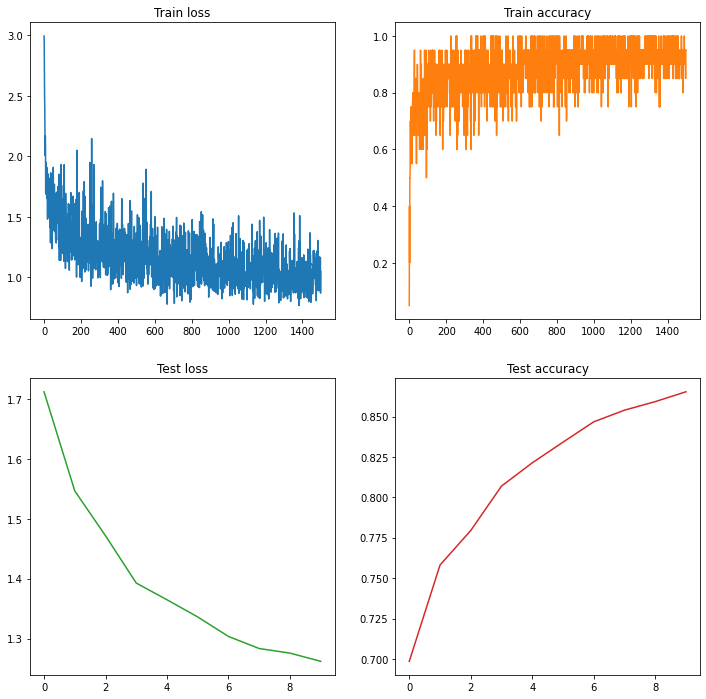

In [10]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
### visualize train_loss and train_accuracy
axs[0, 0].plot(train_loss_tracker)
axs[0, 0].set_title('Train loss')
axs[0, 1].plot(train_accuracy_tracker, 'tab:orange')
axs[0, 1].set_title('Train accuracy')
### visualize test_loss and test_accuracy
axs[1, 0].plot(test_loss_tracker, 'tab:green')
axs[1, 0].set_title('Test loss')
axs[1, 1].plot(test_accuracy_tracker, 'tab:red')
axs[1, 1].set_title('Test accuracy')
plt.show()